## Leaf Classification

In [1]:
%pylab inline
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [2]:
from keras.models import Sequential
from keras.layers import Dense,Dropout,Activation
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

Using Theano backend.


In [3]:
from pylab import rcParams
rcParams['figure.figsize'] = 20,10

In [4]:
data = pd.read_csv('../../Dataset/Leaf Classification/train.csv')
data.head()
ID = data.pop('id').values.tolist()

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 990 entries, 0 to 989
Columns: 193 entries, species to texture64
dtypes: float64(192), object(1)
memory usage: 1.5+ MB


In [6]:
parent_data = data.copy()

In [7]:
print 'Number of Species: {}'.format(len(data.species.unique()))

Number of Species: 99


In [8]:
y = data.pop('species')

In [9]:
y.head()

0              Acer_Opalus
1    Pterocarya_Stenoptera
2     Quercus_Hartwissiana
3          Tilia_Tomentosa
4       Quercus_Variabilis
Name: species, dtype: object

In [10]:
data.head()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.007812,0.023438,0.023438,0.003906,0.011719,0.009766,0.027344,0.0,0.001953,0.033203,...,0.007812,0.000000,0.002930,0.002930,0.035156,0.0,0.0,0.004883,0.000000,0.025391
1,0.005859,0.000000,0.031250,0.015625,0.025391,0.001953,0.019531,0.0,0.000000,0.007812,...,0.000977,0.000000,0.000000,0.000977,0.023438,0.0,0.0,0.000977,0.039062,0.022461
2,0.005859,0.009766,0.019531,0.007812,0.003906,0.005859,0.068359,0.0,0.000000,0.044922,...,0.154300,0.000000,0.005859,0.000977,0.007812,0.0,0.0,0.000000,0.020508,0.002930
3,0.000000,0.003906,0.023438,0.005859,0.021484,0.019531,0.023438,0.0,0.013672,0.017578,...,0.000000,0.000977,0.000000,0.000000,0.020508,0.0,0.0,0.017578,0.000000,0.047852
4,0.005859,0.003906,0.048828,0.009766,0.013672,0.015625,0.005859,0.0,0.000000,0.005859,...,0.096680,0.000000,0.021484,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.031250


### Benchmark Model Using Logistic Regression

In [11]:
from sklearn.preprocessing import LabelEncoder

In [12]:
label = LabelEncoder().fit(y)
y = label.transform(y)
print y.shape

(990,)


In [13]:
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit(data).transform(data)

In [14]:
from sklearn.linear_model import LogisticRegression
log = LogisticRegression(C=1000,tol=0.001,solver='lbfgs',multi_class='multinomial')

In [15]:
print X.shape,y.shape

(990, 192) (990,)


In [16]:
log.fit(X,y)

LogisticRegression(C=1000, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='multinomial',
          n_jobs=1, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.001, verbose=0, warm_start=False)

In [17]:
from sklearn.metrics import accuracy_score
print 'Train logloss: {}'.format(log_loss(y,log.predict_proba(X)))

Train logloss: 5.32105916443e-05


### Dimensionality Reduction and Visualizing the Data

In [18]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

In [19]:
pca.fit(data)
T = pca.transform(data)
print T.shape

(990, 3)


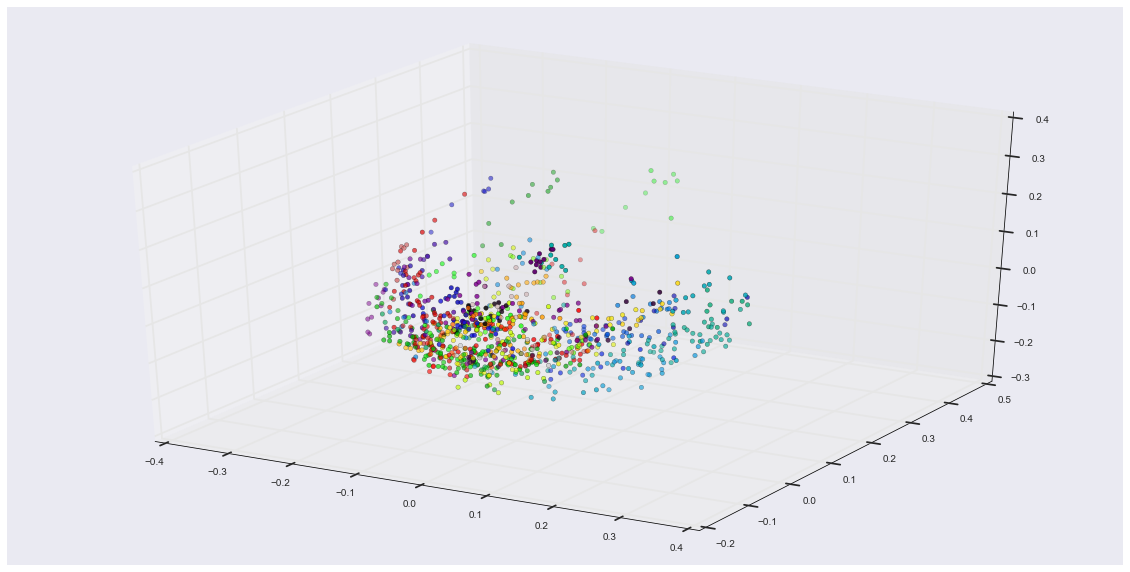

In [20]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(xs=T[:,0],ys=T[:,1],zs=T[:,2],c=y, cmap = 'spectral',marker='o')

In [21]:
print 'Variance retained: {}'.format(pca.explained_variance_ratio_.sum())

Variance retained: 0.338407195749


In [22]:
from sklearn.manifold import Isomap
iso = Isomap(n_neighbors=5,n_components=3)

In [23]:
iso.fit(data)
T = iso.transform(data)

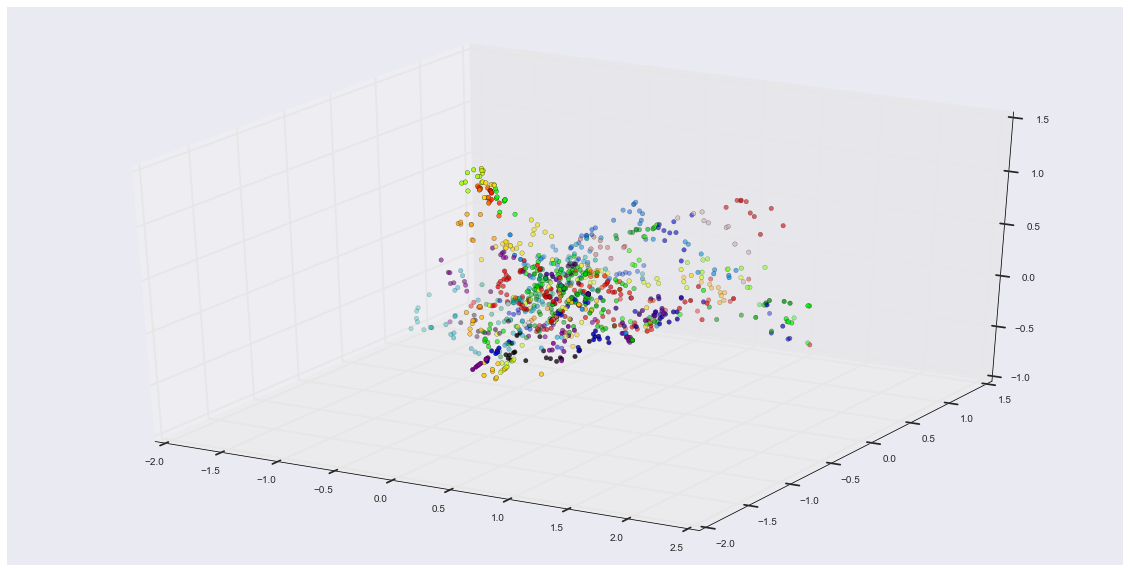

In [24]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(xs=T[:,0],ys=T[:,1],zs=T[:,2],c=y,cmap='spectral',marker='o')

### KNN Classifier

In [25]:
from sklearn.neighbors import KNeighborsClassifier

In [26]:
knn = KNeighborsClassifier(n_neighbors=5)

In [27]:
knn.fit(X,y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [28]:
print X.shape,y.shape

(990, 192) (990,)


In [29]:
print 'Train LogLoss: {}'.format(log_loss(y,knn.predict_proba(X)))

Train LogLoss: 0.0566441511654


### Ensembling KNN and Logistic Regression

In [30]:
from sklearn.metrics import log_loss

In [31]:
knn.fit(X,y)
yPred_knn = knn.predict_proba(X)

In [32]:
log.fit(X,y)
yPred_rfc = log.predict_proba(X)

In [33]:
for i in np.arange(0.1,0.9,0.1):
    print 'KNN Weight: {}, RFC Weight: {}'.format(i,1-i)
    print 'Train Accuracy: {}'.format(log_loss(y,i*yPred_knn+(1-i)*yPred_rfc))

KNN Weight: 0.1, RFC Weight: 0.9
Train Accuracy: 0.00434033175901
KNN Weight: 0.2, RFC Weight: 0.8
Train Accuracy: 0.00882076176019
KNN Weight: 0.3, RFC Weight: 0.7
Train Accuracy: 0.0135179642205
KNN Weight: 0.4, RFC Weight: 0.6
Train Accuracy: 0.0184609036912
KNN Weight: 0.5, RFC Weight: 0.5
Train Accuracy: 0.0236861864257
KNN Weight: 0.6, RFC Weight: 0.4
Train Accuracy: 0.0292414829175
KNN Weight: 0.7, RFC Weight: 0.3
Train Accuracy: 0.0351913712596
KNN Weight: 0.8, RFC Weight: 0.2
Train Accuracy: 0.0416282277295


### Submission File

In [34]:
test = pd.read_csv('../../Dataset/Leaf Classification/test.csv')
print test.shape

(594, 193)


In [35]:
index = test.pop('id')
test.head()

,margin1,margin2,margin3,margin4,margin5,margin6,margin7,margin8,margin9,margin10,...,texture55,texture56,texture57,texture58,texture59,texture60,texture61,texture62,texture63,texture64
0,0.019531,0.009766,0.078125,0.011719,0.003906,0.015625,0.005859,0.0,0.005859,0.023438,...,0.006836,0.000000,0.015625,0.000977,0.015625,0.0,0.0,0.000000,0.003906,0.053711
1,0.007812,0.005859,0.064453,0.009766,0.003906,0.013672,0.007812,0.0,0.033203,0.023438,...,0.000000,0.000000,0.006836,0.001953,0.013672,0.0,0.0,0.000977,0.037109,0.044922
2,0.000000,0.000000,0.001953,0.021484,0.041016,0.000000,0.023438,0.0,0.011719,0.005859,...,0.128910,0.000000,0.000977,0.000000,0.000000,0.0,0.0,0.015625,0.000000,0.000000
3,0.000000,0.000000,0.009766,0.011719,0.017578,0.000000,0.003906,0.0,0.003906,0.001953,...,0.012695,0.015625,0.002930,0.036133,0.013672,0.0,0.0,0.089844,0.000000,0.008789
4,0.001953,0.000000,0.015625,0.009766,0.039062,0.000000,0.009766,0.0,0.005859,0.000000,...,0.000000,0.042969,0.016602,0.010742,0.041016,0.0,0.0,0.007812,0.009766,0.007812


In [36]:
test = StandardScaler().fit(test).transform(test)
print test.shape

(594, 192)


In [37]:
yPred = np.asarray(knn.predict_proba(test)*0.1+0.9*log.predict_proba(test))
print yPred.shape

(594, 99)


In [38]:
yPred = pd.DataFrame(yPred,index=index,columns=sort(parent_data.species.unique()))

In [39]:
print yPred.shape
yPred.head()

(594, 99)


,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
id,,,,,,,,,,,,,,,,,,,,,
4,1.482119e-11,1.689733e-11,2.868373e-15,1.751339e-09,7.272128e-11,1.327188e-10,1.701199e-16,8.857708e-13,9.289008e-13,3.823736e-09,...,9.831606e-16,3.013400e-10,3.375724e-11,6.807204e-13,1.373090e-09,1.377610e-13,2.752198e-14,3.666996e-15,1.869415e-07,2.870087e-14
7,6.921292e-11,3.531194e-11,7.768175e-09,1.398245e-07,7.987170e-12,7.932330e-11,1.525853e-06,7.092119e-11,1.621139e-10,4.323754e-11,...,2.091240e-09,3.378711e-09,1.414306e-12,6.579132e-13,1.314842e-14,4.103017e-07,8.984662e-10,2.543736e-07,2.691917e-12,3.037703e-10
9,7.226092e-08,9.987281e-01,2.693619e-09,6.361262e-10,1.029178e-03,2.717933e-08,1.540083e-09,1.174811e-05,3.893717e-05,9.615243e-06,...,1.193895e-07,1.182471e-09,1.597758e-08,5.949091e-09,2.989565e-09,6.184708e-09,1.750300e-07,3.096296e-11,1.298071e-09,1.836194e-05
12,1.461005e-09,1.013912e-03,2.426568e-09,3.441573e-10,1.770924e-08,7.896951e-12,5.587575e-06,1.394741e-07,4.442135e-06,3.323650e-06,...,2.398097e-07,2.065806e-09,3.190621e-08,8.153022e-10,3.843722e-10,1.047578e-06,2.692383e-03,4.424566e-09,2.030983e-10,1.391359e-05
13,6.274367e-09,2.032681e-08,4.723837e-13,2.655214e-13,2.459025e-09,3.201893e-13,1.236349e-09,4.192396e-09,3.851078e-06,2.662213e-08,...,1.785107e-08,1.629558e-11,2.911723e-07,1.465038e-10,2.677735e-07,1.037487e-07,5.363444e-06,1.985341e-10,1.503649e-09,2.699201e-10


In [40]:
fp = open('submission.csv','wb')
fp.write(yPred.to_csv())

## Using Neural Networks

In [41]:
model = Sequential()
model.add(Dense(1024,input_dim=192))
model.add(Dropout(0.2))
model.add(Activation('sigmoid'))
model.add(Dense(512))
model.add(Dropout(0.3))
model.add(Activation('sigmoid'))
model.add(Dense(99))
model.add(Activation('softmax'))

In [42]:
y_cat = to_categorical(y)
print y_cat.shape

(990, 99)


In [43]:
X = StandardScaler().fit(X).transform(X)

In [44]:
X_train,X_test,y_train,y_test = train_test_split(X,y_cat,test_size=0.3,random_state=7)
print X_train.shape,y_train.shape

(693, 192) (693, 99)


In [45]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop')

In [46]:
hist = model.fit(X_train,y_train,batch_size=128,nb_epoch=100,verbose=0)

In [47]:
score = model.evaluate(X_test,y_test)
print 'CV Score: {}'.format(round(score,3))

297/297 [==============================] - 0s     
CV Score: 0.026


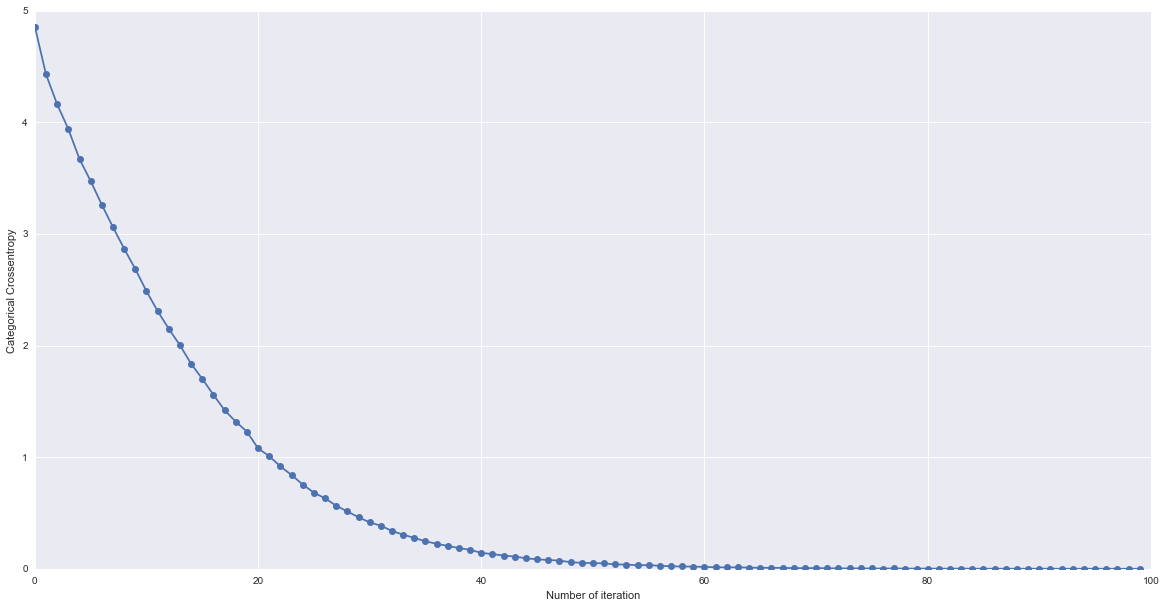

In [48]:
plt.plot(hist.history['loss'], 'o-')
plt.xlabel('Number of iteration')
plt.ylabel('Categorical Crossentropy')

### Submission File

In [49]:
print X.shape,y_cat.shape

(990, 192) (990, 99)


In [50]:
model = Sequential()
model.add(Dense(1024,input_dim=192))
model.add(Dropout(0.2))
model.add(Activation('sigmoid'))
model.add(Dense(512))
model.add(Dropout(0.3))
model.add(Activation('sigmoid'))
model.add(Dense(99))
model.add(Activation('softmax'))

In [51]:
model.compile(loss='categorical_crossentropy',optimizer='rmsprop')

In [53]:
history = model.fit(X,y_cat,batch_size=128,nb_epoch=100,verbose=0)

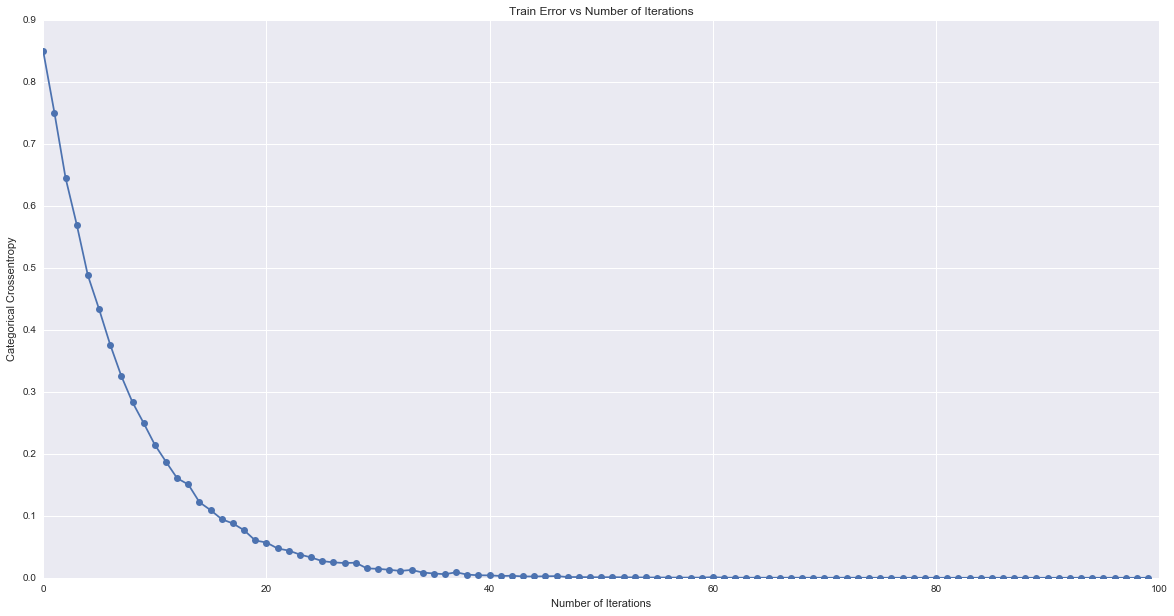

In [54]:
plt.plot(history.history['loss'],'o-')
plt.xlabel('Number of Iterations')
plt.ylabel('Categorical Crossentropy')
plt.title('Train Error vs Number of Iterations')

In [55]:
yPred = model.predict_proba(test)

594/594 [==============================] - 0s     


In [56]:
yPred = pd.DataFrame(yPred,index=index,columns=sort(parent_data.species.unique()))

In [57]:
print yPred.shape
yPred.head()

(594, 99)


,Acer_Capillipes,Acer_Circinatum,Acer_Mono,Acer_Opalus,Acer_Palmatum,Acer_Pictum,Acer_Platanoids,Acer_Rubrum,Acer_Rufinerve,Acer_Saccharinum,...,Salix_Fragilis,Salix_Intergra,Sorbus_Aria,Tilia_Oliveri,Tilia_Platyphyllos,Tilia_Tomentosa,Ulmus_Bergmanniana,Viburnum_Tinus,Viburnum_x_Rhytidophylloides,Zelkova_Serrata
id,,,,,,,,,,,,,,,,,,,,,
4,3.132772e-15,1.247058e-15,3.239626e-21,4.606291e-13,4.538271e-16,2.410689e-13,3.264466e-18,9.020635e-18,4.172536e-15,1.851701e-14,...,3.035143e-18,2.245958e-14,6.938653e-14,2.089224e-17,1.170408e-15,5.608547e-17,2.546183e-18,1.909380e-21,1.151584e-11,7.579857e-21
7,1.251843e-16,4.406001e-15,8.354648e-15,1.976316e-11,7.778884e-18,5.385330e-13,2.378893e-13,4.250593e-17,1.020563e-17,1.633559e-15,...,1.777240e-15,1.149146e-15,8.591673e-18,4.892358e-20,1.864742e-23,4.267086e-12,1.448430e-14,1.925354e-14,1.316608e-15,2.521394e-16
9,1.220371e-13,9.999998e-01,1.747799e-14,1.512339e-16,2.187376e-07,4.615058e-13,5.944774e-15,2.021336e-10,1.584547e-10,1.765453e-10,...,2.828837e-14,2.861027e-17,1.194557e-16,2.463503e-15,2.950393e-17,1.695416e-13,2.578100e-13,9.714822e-19,2.009763e-15,4.418182e-09
12,1.832353e-13,2.682576e-05,2.949497e-11,4.118575e-13,2.647857e-12,1.198399e-14,7.441614e-07,2.351304e-09,1.055148e-09,1.517396e-07,...,7.674079e-13,1.473893e-14,4.572257e-13,2.384668e-12,3.944312e-14,3.772037e-08,1.643238e-06,6.091136e-12,8.677367e-16,7.695752e-07
13,4.867572e-16,6.954980e-13,3.659958e-21,1.655442e-19,2.557508e-15,3.699151e-19,5.650647e-14,8.261085e-17,2.819648e-10,9.813446e-13,...,7.251912e-13,1.340098e-17,7.479020e-12,1.595266e-16,1.959448e-11,6.624104e-14,5.654025e-09,1.797614e-15,7.081540e-14,6.716760e-15


In [58]:
fp = open('submission_nn.csv','wb')
fp.write(yPred.to_csv())

## Considering the Images Dataset

In [59]:
import glob
from scipy.misc import imread
from PIL import Image
import pandas as pd
import numpy as np

In [60]:
data_train,data_test = {},{}
for fname in glob.glob('../../Dataset/Leaf Classification/images/*.jpg'):
    image = Image.open(fname)
    image.thumbnail((20, 20), Image.ANTIALIAS)
    image = np.asarray(image).reshape(image.size[0]*image.size[1])
    i = int(fname.split('/')[-1].split('.')[0])
    if i in ID:
        data_train[i] = (np.asarray(image.tolist() + [0 for j in range(400-image.shape[0])]))
    else:
        data_test[i] = (np.asarray(image.tolist() + [0 for j in range(400-image.shape[0])]))

In [61]:
data_train = pd.DataFrame(data_train.values(),columns=['pixel{}'.format(i) for i in range(400)],index=data_train.keys())
data_train.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399
1,0,0,0,0,0,0,0,2,0,26,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,18,26,33,39,35,33,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,1,3,0,0,0,0,9,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,3,0,0,0,0,38,54,42,...,0,0,0,0,0,0,0,0,0,0


In [62]:
data_test = pd.DataFrame(data_test.values(),columns=['pixel{}'.format(i) for i in range(400)],index=data_test.keys())
data_test.head()

,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel390,pixel391,pixel392,pixel393,pixel394,pixel395,pixel396,pixel397,pixel398,pixel399
4,0,0,0,2,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,2,0,0,0,5,0,17,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,2,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
12,0,0,1,4,0,0,0,18,50,56,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,3,0,0,...,0,0,0,0,0,0,0,0,0,0


In [63]:
print 'TRAIN DATA SHAPE: {}'.format(data_train.shape)
print 'TEST DATA SHAPE: {}'.format(data_test.shape)

TRAIN DATA SHAPE: (990, 400)
TEST DATA SHAPE: (594, 400)


Populating the interactive namespace from numpy and matplotlib
1


`%matplotlib` prevents importing * from pylab and numpy


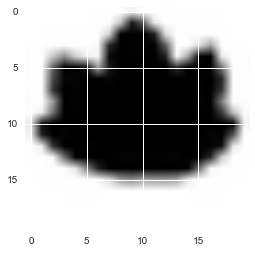

In [64]:
%pylab inline
print data_train.index[0]
plt.imshow(data_train.iloc[0,:].reshape(20,20))

4


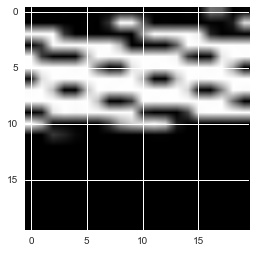

In [65]:
print data_test.index[0]
plt.imshow(data_test.iloc[0,:].reshape(20,20),cmap='gray')

7


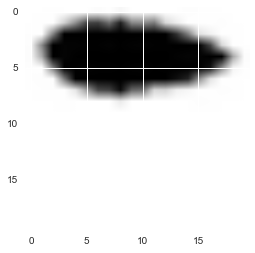

In [66]:
print data_test.index[1]
plt.imshow(data_test.iloc[1,:].reshape(20,20))

In [67]:
species = parent_data.species.astype('category').cat.codes
species.head()

0     3
1    49
2    65
3    94
4    84
dtype: int8